# Prepare labelled input for the Machine Learning algorithm
# (i.e. locations where moss&lichen fractional cover changes can be related to meteorological parameters from ERA5-Land)

# Copernicus Global Land Cover
## Percentage of 100m pixel that is covered by a specific class of land cover
## Valid values 0	100, 200 = masked sea, 255 = missing

In [1]:
!date

Sun Mar 12 16:10:07 UTC 2023


In [2]:
pip install vaex

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
import pandas as pd
import s3fs
import xarray as xr
import vaex

# Input datasets, either from s3 storage or local files

# If data is available locally then jump the following cells

### Define s3 storage parameters

In [ ]:
client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
store = s3fs.S3FileSystem(anon=False, client_kwargs=client_kwargs)
store.ls('Data', detail=True, refresh=True)

## Copernicus Global Land Cover data  from 2015-01-01 to 2019-12-31 already available as a netCDF file stored on EOSC (CESNET)
## Troms og Finnmark
### Mosses and lichens, bare, grass, shrubs and trees

In [ ]:
s3path = 'Data/C_GlobalLandCover_20150101_20190101_Troms-Finnmark.nc'

In [ ]:
GLC_AOI = xr.open_dataset(store.open(s3path))

In [ ]:
GLC_AOI

## ERA5-land data from 2015-01-01 to 2019-12-31 - already available as a netCDF file stored on EOSC (CESNET)
## 2m Temperature, Snow depth, Total precipitation

In [ ]:
s3path = 'Data/reanalysis-era5-land_hourly_2015-01-01_2022-12-31_Troms-Finnmark_T2m-SD-TP.nc'

In [ ]:
ERA5land = xr.open_dataset(store.open(s3path))

In [ ]:
ERA5land

# Datasets from **local** files

In [4]:
path = '/home/jovyan/Arctic/Vegetation_in_Troms_and_Finnmark/data/'

In [40]:
# World Land cover data from 2015-01-01 to 2019-12-31- already available as a netCDF file stored locally
GLC_filename = os.path.join(path, 'C_GlobalLandCover_20150101_20190101_Troms-Finnmark.nc')
GLC_AOI = xr.open_dataset(GLC_filename, engine = 'netcdf4')

In [6]:
# ERA5-land data already available as a netCDF file stored locally
ERA5_filename = os.path.join(path, 'reanalysis-era5-land_hourly_2015-01-01_2022-12-31_Troms-Finnmark_T2m-SD-TP.nc')
ERA5land = xr.open_dataset(ERA5_filename, engine = 'netcdf4')

In [41]:
GLC_AOI = GLC_AOI.rename(x='lon', y='lat', t='time')

In [42]:
# Drop variables not directly of interest here
GLC_AOI = GLC_AOI.drop_vars(['crs',
                             'Crops_CoverFraction_layer',
                             'Discrete_Classification_map', 
                             'Discrete_Classification_proba',
                             'Forest_Type_layer',
                             'Snow_CoverFraction_layer',
                             'BuiltUp_CoverFraction_layer',
                             'PermanentWater_CoverFraction_layer',
                             'SeasonalWater_CoverFraction_layer',
                             'DataDensityIndicator',
                             'Change_Confidence_layer',
                             'dataMask'])

In [43]:
GLC_AOI = GLC_AOI.rename(Bare_CoverFraction_layer = 'Bare',
                         Grass_CoverFraction_layer = 'Grass',
                         MossLichen_CoverFraction_layer = 'Lichen',
                         Shrub_CoverFraction_layer = 'Shrub',
                         Tree_CoverFraction_layer = 'Tree')

In [44]:
GLC_AOI

<xarray.Dataset>
Dimensions:  (time: 5, lon: 16709, lat: 3064)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 ... 2019-01-01
  * lon      (lon) float64 15.6 15.6 15.6 15.6 15.6 ... 31.06 31.06 31.06 31.07
  * lat      (lat) float64 71.19 71.19 71.19 71.18 ... 68.35 68.35 68.35 68.35
Data variables:
    Bare     (time, lat, lon) float32 ...
    Grass    (time, lat, lon) float32 ...
    Lichen   (time, lat, lon) float32 ...
    Shrub    (time, lat, lon) float32 ...
    Tree     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [45]:
# Troms & Finnmark Global Land Cover area
GLC_AOI_min_lon = GLC_AOI.lon.min()
GLC_AOI_max_lon = GLC_AOI.lon.max()
GLC_AOI_min_lat = GLC_AOI.lat.min()
GLC_AOI_max_lat = GLC_AOI.lat.max()
print(GLC_AOI_min_lon.values, GLC_AOI_max_lon.values, GLC_AOI_min_lat.values, GLC_AOI_max_lat.values)

15.595313502963002 31.06568387333461 68.35153627792579 71.18764738903712


In [46]:
print(GLC_AOI['Lichen'].min(), GLC_AOI['Lichen'].max())

<xarray.DataArray 'Lichen' ()>
array(1.) <xarray.DataArray 'Lichen' ()>
array(255.)


In [47]:
GLC_AOI['Lichen'] = GLC_AOI['Lichen'].where(GLC_AOI['Lichen'] <= 100)

In [48]:
print(GLC_AOI['Lichen'].min(), GLC_AOI['Lichen'].max())

<xarray.DataArray 'Lichen' ()>
array(1.) <xarray.DataArray 'Lichen' ()>
array(100.)


In [51]:
mask = GLC_AOI['Lichen'].prod(dim = 'time', min_count = 5, skipna=True)

In [52]:
mask = xr.where(mask > 0, 1, 0)

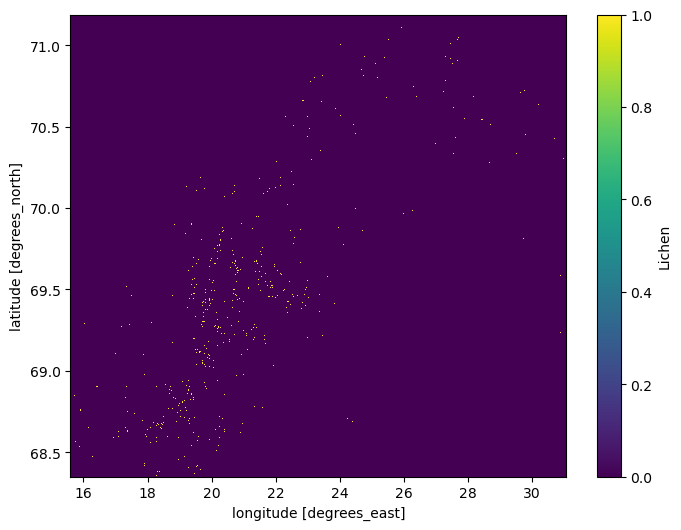

In [53]:
mask.plot(size=6)

In [60]:
mask.sum()

<xarray.DataArray 'Lichen' ()>
array(95934)

## Mask not used, yet 

In [57]:
de = GLC_AOI.where(mask == 1).to_dataframe()

In [58]:
de = de.reset_index()

In [59]:
de

,time,lat,lon,Bare,Grass,Lichen,Shrub,Tree
0,2015-01-01,71.187647,15.595314,NaN,NaN,NaN,NaN,NaN
1,2015-01-01,71.187647,15.596239,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,71.187647,15.597165,NaN,NaN,NaN,NaN,NaN
3,2015-01-01,71.187647,15.598091,NaN,NaN,NaN,NaN,NaN
4,2015-01-01,71.187647,15.599017,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
255981875,2019-01-01,68.351536,31.061980,NaN,NaN,NaN,NaN,NaN
255981876,2019-01-01,68.351536,31.062906,NaN,NaN,NaN,NaN,NaN
255981877,2019-01-01,68.351536,31.063832,NaN,NaN,NaN,NaN,NaN
255981878,2019-01-01,68.351536,31.064758,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Only keep the locations where there is lichen
dd = de[(de['Lichen'] > 0) & (de['Lichen'] <= 100)]

In [ ]:
dd

## Each year in a separate dataset and keep only the first 183 days

In [ ]:
Year = 2015
Number_of_days = 183
print('x = WLC(' + str(Year)+ ') joined with ERA5land(' + str(Year + 1) + ')')
print('y = WLC(' + str(Year + 1) + ')')

In [ ]:
# Only keep locations with lichen for the current year
df = dd.loc[dd['time'] == str(Year) + '-01-01']
dg = de.loc[de['time'] == str(Year + 1) + '-01-01']

In [ ]:
df

In [ ]:
# Replace NaNs by 0
for col in ['Bare', 'Grass', 'Lichen', 'Shrub', 'Tree']:
    print(col)
    df[col] = df[col].fillna(0)
    dg[col] = dg[col].fillna(0)

In [ ]:
# Calculate total fractional coverage of bare, grass, lichen, shrub and tree (should be 100)
df['Total']  = (df['Bare'] + df['Grass'] + df['Lichen'] + df['Shrub'] + df['Tree'])
dg['Total']  = (dg['Bare'] + dg['Grass'] + dg['Lichen'] + dg['Shrub'] + dg['Tree'])

In [ ]:
df

In [ ]:
# Normalize the fractional cover
for col in ['Bare', 'Grass', 'Lichen', 'Shrub', 'Tree']:
    print(col)
    df[col] = df[col] / df['Total']
    dg[col] = dg[col] / dg['Total']

In [ ]:
# Drop the *Total* column
df = df.drop(['Total'], axis=1)
dg = dg.drop(['Total'], axis=1)

In [ ]:
df

In [ ]:
dg

In [ ]:
# Convert to VAEX
dvx = vaex.from_pandas(df)
dvy = vaex.from_pandas(dg)

In [ ]:
dvx

In [ ]:
dvy

In [ ]:
# Find the correspondind ERA5-land lat-lon
# Careful with the latitude, in reverse order
dvx['ERA5_lon_index'] = ((dvx.lon - 15.59) / 0.1).astype('int').values
dvx['ERA5_lat_index'] = 28 - ((dvx.lat - 68.35) / 0.1).astype('int').values
dvy['ERA5_lon_index'] = ((dvy.lon - 15.59) / 0.1).astype('int').values
dvy['ERA5_lat_index'] = 28 - ((dvy.lat - 68.35) / 0.1).astype('int').values

In [ ]:
dvx

# Adding columns with the ERA5-land longitude and latitude to dv

In [ ]:
dvx['ERA5_lon'] = ERA5land.sel(time="2015-01-01").longitude[dvx['ERA5_lon_index'].values].values
dvx['ERA5_lat'] = ERA5land.sel(time="2015-01-01").latitude[dvx['ERA5_lat_index'].values].values
dvy['ERA5_lon'] = ERA5land.sel(time="2015-01-01").longitude[dvy['ERA5_lon_index'].values].values
dvy['ERA5_lat'] = ERA5land.sel(time="2015-01-01").latitude[dvy['ERA5_lat_index'].values].values

In [ ]:
dvx

## Extract ERA5 data for  the selected period of the year (when RoS events mostly occur)

In [ ]:
ERA5 = ERA5land.sel(time=slice(str(Year + 1) + '-01-01', str(Year + 1)  + '-12-31'))

In [ ]:
ERA5 = ERA5.isel(time=range(Number_of_days * 24))

In [ ]:
ERA5 = ERA5.isel(expver = 0)

In [ ]:
ERA5

In [ ]:
# Extract ERA5 t2m, tp and sd fields 
ERA5_t2m = ERA5.where(ERA5['latitude'].isin(dvx['ERA5_lat'].values) & ERA5['longitude'].isin(dvx['ERA5_lon'].values))['t2m']
ERA5_tp = ERA5.where(ERA5['latitude'].isin(dvx['ERA5_lat'].values) & ERA5['longitude'].isin(dvx['ERA5_lon'].values))['tp']
ERA5_sd = ERA5.where(ERA5['latitude'].isin(dvx['ERA5_lat'].values) & ERA5['longitude'].isin(dvx['ERA5_lon'].values))['sd']

## Rain on Snow criteria (according to https://www.hydrol-earth-syst-sci.net/23/2983/2019/hess-23-2983-2019.pdf)
 * total rainfall volume of at least 20 mm within 12 h
### or 
 * air temperatures above 0C (273.15K)
 * and initial snowpack depth of at least 10 cm

In [ ]:
# Normalizing temperature, total precipitation and snow depth values accordidng to these criteria
ERA5_t2m = ERA5_t2m / 273.15
ERA5_tp = ERA5_tp / 0.02 * 12.
ERA5_sd = ERA5_sd / 0.1

In [ ]:
df_t2m = ERA5_t2m.stack(z=['latitude', 'longitude']).to_pandas().transpose().reset_index()
df_tp = ERA5_tp.stack(z=['latitude', 'longitude']).to_pandas().transpose().reset_index()
df_sd = ERA5_sd.stack(z=['latitude', 'longitude']).to_pandas().transpose().reset_index()

In [ ]:
df_tp = df_tp.drop(columns=['latitude', 'longitude'])
df_sd = df_sd.drop(columns=['latitude', 'longitude'])

In [ ]:
# Create labels for ERA5-land variables to replace the dates
label_t2m = ['latitude', 'longitude']
label_tp = list()
label_sd = list()
for i in range(Number_of_days * 24):
    label_t2m.append('t2m_'+ str(i))
    label_tp.append('tp_'+ str(i))
    label_sd.append('sd_'+ str(i))

In [ ]:
df_t2m.set_axis(label_t2m, axis="columns", inplace=True)
df_tp.set_axis(label_tp, axis="columns", inplace=True)
df_sd.set_axis(label_sd, axis="columns", inplace=True)

In [ ]:
##  Glue together df_t2m, df_tp and df_sd
df = pd.concat([df_t2m, df_tp, df_sd], axis = 1)

In [ ]:
df

In [ ]:
# Add combined lon_lat column to df
df['lon_lat'] = (df['longitude'] * 100).astype('int') + (df['latitude'] * 100).astype('int') / 100000

In [ ]:
# Drop latitude and longitude columns which are not used anymore in df
df = df.drop(columns=['latitude', 'longitude'])

In [ ]:
df

In [ ]:
# Add combined lon_lat column to dv x & y
dvx['lon_lat'] = (dvx['ERA5_lon'] * 100).astype('int') + (dvx['ERA5_lat'] * 100).astype('int') / 100000

In [ ]:
dvx

In [ ]:
# Drop unused columns in dv x & y
dwx = dvx.drop(columns=['time', 'ERA5_lon_index', 'ERA5_lat_index', 'ERA5_lon', 'ERA5_lat'])
dwy = dvy.drop(columns=['time', 'ERA5_lon_index', 'ERA5_lat_index', 'ERA5_lon', 'ERA5_lat'])

In [ ]:
dwx

In [ ]:
dwy

In [ ]:
# Convert to panda dw x & y
dwx_pandas = dwx.to_pandas_df()
dwy_pandas = dwy.to_pandas_df()

## Join dwx (WLC) with df (ERA5 t2m-tp-sd)

In [ ]:
dwx_pandas

In [ ]:
# Join dwx (WLC) with df (ERA5 t2m-tp-sd)
dx = dwx_pandas.set_index('lon_lat').join(df.set_index('lon_lat'), on='lon_lat')

In [ ]:
dx

In [ ]:
# Drop the Rows with NaN Values
dx = dx.dropna()

In [ ]:
dx = dx.reset_index()

In [ ]:
dx = dx.drop(columns=['lon_lat'])

In [ ]:
dx

In [ ]:
## Save into **local** HDF5 file without index
x_filename = os.path.join(path, 'x_tps_' + str(Year) + '.hdf')
print(x_filename)
dx.to_hdf(x_filename, key='df', mode="w", index=False)

## Find locations with lichen in the following year corresponding to those in current year

In [ ]:
dwx_pandas = dx[['lon', 'lat']]

In [ ]:
dwx_pandas

In [ ]:
dwy_pandas

In [ ]:
# Add combined lat-lon column to dv x & y
dwx_pandas['lon_lat'] = (dwx_pandas['lon'] * 100000).astype('int') + (dwx_pandas['lat'] * 100000).astype('int') / 10000000
dwy_pandas['lon_lat'] = (dwy_pandas['lon'] * 100000).astype('int') + (dwy_pandas['lat'] * 100000).astype('int') / 10000000

In [ ]:
dwx_pandas = dwx_pandas.drop(columns=['lon', 'lat'])
dwy_pandas = dwy_pandas.drop(columns=['lon', 'lat'])

In [ ]:
dwx_pandas

In [ ]:
dwy_pandas

In [ ]:
## Join dwx with dwy
dy = dwx_pandas.set_index('lon_lat').join(dwy_pandas.set_index('lon_lat'), on='lon_lat')

In [ ]:
dy

In [ ]:
# Replace NaNs by 0
for col in ['Bare', 'Grass', 'Lichen', 'Shrub', 'Tree']:
    print(col)
    dy[col] = dy[col].fillna(0)

In [ ]:
dy = dy.reset_index().drop(columns=['lon_lat'])

In [ ]:
dy

In [ ]:
## Save into **local** HDF5 file without index
y_filename = os.path.join(path, 'y_' + str(Year) + '.hdf')
print(y_filename)
dy.to_hdf(y_filename, key='dg', mode="w", index=False)

In [ ]:
print('Finished!')